# Figure 12 - Cross Section (Summer)

## 1 - Import Necessary Modules

In [2]:
import cartopy 
import cartopy.io.shapereader as shpreader 
import cartopy.io.shapereader as Reader 
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np 
import proplot as plot
import proplot
import salem
import xarray as xr 

from cartopy.feature import ShapelyFeature 
from glob import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from netCDF4 import Dataset 
from shapely.geometry import mapping
from visjobs.visualize import easy_plot
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

# warnings
import warnings
warnings.filterwarnings('ignore')

## 2 - Functions to Open Datasets and Select Relevant Variables

In [2]:
# AÇIKLAMALARDA REFLEKTİVİTE YERİNE var OLDUĞUNU VARSAY
# BURADA DİREKT OLARAK CROSS SECTION DEĞERLERİNİ ENSEMBLE MEAN ALIP DÖNECEĞİZ.
def open_wrf_with_variable(member_list, start, end, var, run_type, lat1, lon1, lat2, lon2):
    """ ÖZET:
    Buradaki olay şu: tüm ensemble memberlarının yağış verilerini salem ile açıyoruz, daha sonra istenilen zaman aralığına kısıyoruz bu veriyi,
    daha sonra bu modifiye edilmiş ensemble verilerini bir listede biriktirip concat ediyoruz ens boyutu üzerinde, daha sonra bu veri'nin ensemble ortalamasını
    alıyoruz, daha sonra ensemble ortalamasını kullanıcıya saatlik olarak mı döneceğiz yoksa zaman aralığı toplamı mı olarak döneceğiz buna karar veriyoruz.
    
        PARAMETERS:
    member_list: ensemble member adlarının listesi (veriyi açmak için),
    start, end: start ve end olarak time indexleri yaratıp verilmeli,
    run_type: urban veya nourban stringleri geçirilmeli (hangi veriyi açacağız?),
    
        RETURNS:
    Tüm ensemble verilerini dbz için concat eder "ens" boyutu üzerinde döner. 
    
    """
    ## ----------------------------------------------------- ## ADIM 1
    # içinde saatlik wrf verilerini biriktireceğimiz liste
    time_sliced_ensemble = []
    for ens in member_list:
        # hangi ensemble üyesinde olduğumuzu belirtelim
        print("{} ensemble'ı çözülüyor..".format(ens))
        
        ALL = Dataset(r'\summer_datasets\ankara_{}_{}\wrfout_d03_2016-08-26_00_00_00'.format(ens, run_type))
        
        dbzs_with_time = []
        # burada time dimensionu üzerinde dönüp tüm dbz leri time boyutunda concat edeceğim
        # maalesef getvar özelliği sadece tek bir zaman dilimini açmakta..
        for t in range(start, end):
            # max reflectivity açalım tek bir zaman dilimi için
            
            
            dbz = getvar(ALL, var, timeidx=t)   
            # Extract the model pressure 
            z = getvar(ALL, "pressure")

            # Create the start point and end point for the cross section
            start_point = CoordPair(lat=lat1, lon=lon1)
            end_point = CoordPair(lat=lat2, lon=lon2)

            # Compute the vertical cross-section interpolation.  Also, include the
            # lat/lon points along the cross-section.
            cross = vertcross(dbz, z, wrfin=ALL, start_point=start_point,
                                       end_point=end_point, latlon=True, meta=True)
            # bu zaman dilimini bir listeye atayalım ve dolduralım
            dbzs_with_time.append(cross)
                
            
            print('{}: {}/{} zaman adımı bitti'.format(ens, t, end))
        
        # tek bir ensembleın tüm zamanlarının olduğu max reflectivity değişkenlerini concat edelim ve ensemble listesine atayalım
        tempor_concat = xr.concat(dbzs_with_time, dim='Time')
        time_sliced_ensemble.append(tempor_concat)
        
        
        # veriyi kapatalım
        ALL.close()
        
    ## ----------------------------------------------------- ## ADIM 2
    
    # saatlik verilerimizi concat edelim ens boyutu üzerinde
    ensemble_runs = xr.concat(time_sliced_ensemble, dim='ens')
    ensemble_runs['ens'] = member_list
    
    return ensemble_runs.mean(dim='ens')
        

## 3. Function to Plot Facet Map

In [3]:
# URBAN - NOURBAN HOURLY HARİTALARI ÇİZERKEN CONTOURF'İ PCOLORMESH OLARAK DEĞİŞTİR!
def plot_facet_map(theta_e_data_urban, wa_data_urban, theta_e_data_nourban, wa_data_nourban,
                   ncols, nrows, levels_theta_e, levels_wa, cmap, extend, 
                   ticks, cb_loc, run_save, var_save, pre_save, pair_number, season, mphysics, draw_colorbar = False):
    #Starting the plotting
    fig, axs = plot.subplots(ncols=ncols, nrows=nrows,)

    #format the plot
    axs.format( 
        abc=True, abcstyle='(a)', abcloc='ur', )
    
    axs.format(ylim=(1000, 200), yscale='log', ylabel='Pressure (hPa)', ylocator=100,)
    #axs.format()

    i=0
    for ax in axs:
        
        if i <= 3:
        
            m=ax.contour(x, y.squeeze(), theta_e_data_urban[i], levels = levels_theta_e, colors = 'black',
                            zorder = 0.02,  labels=True, lw=0.6,)

            n=ax.contourf(x, y.squeeze(), wa_data_urban[i], levels = levels_wa, cmap=cmap, extend=extend, 
                            zorder = 0.01,)

            utc = str(theta_e_data_urban[i]['Time'].values)[11:13]
            ax.format(ultitle = '{} {} UTC'.format(run_save[:5], utc), fontsize = 10, )
            i=i+1
            
        else:
            # burada i 4'e geldiği benim de i'yi 0'a döndürmem gerektiği için aşşağıdaki i'lerden 4 çıkaracağım çünkü nourban için yeni satıra geçtik.
            m=ax.contour(x, y.squeeze(), theta_e_data_nourban[i-4], levels = levels_theta_e, colors = 'black',
                            zorder = 0.02,  labels=True, lw=0.6,)

            n=ax.contourf(x, y.squeeze(), wa_data_nourban[i-4], levels = levels_wa, cmap=cmap, extend=extend, 
                            zorder = 0.01,)

            utc = str(theta_e_data_nourban[i-4]['Time'].values)[11:13]
            ax.format(ultitle = '{} {} UTC'.format(run_save[7:], utc), fontsize = 10, )
            i=i+1
            
    
    if draw_colorbar == True:
        fig.colorbar(n, label='m/s', 
                     ticks = ticks, loc = cb_loc)#Adding colorbar with label

    #Saving the Figure
    #save figure
    plt.savefig(r'{}\{}\{}\{}\{}_{}_{}_{}_{}_{}.jpeg'.format(pre_pathing, season, run_save, var_save, season, pair_number, pre_save, run_save, var_save, mphysics),
                    bbox_inches='tight', optimize=True, progressive=True, dpi=500)



## 4. Open WRF datasets And Find Cross Section Coordinates

In [4]:
%%capture
# -------------------------------URBAN ---------------------------------------------------

member_list = ['lin', 'thompson', 'wsm6']
start = 59 # event başlangıcının verideki time indexi
end = 63 # event bitişinin verideki time indeksi
var = 'theta_e'
run_type = 'urban'
lat1, lon1 = 40.003827, 32.496339
lat2, lon2 = 39.833199, 32.979051

urban_ens_mean_daily_total = open_wrf_with_variable(member_list, start, end, var,  run_type, lat1, lon1, lat2, lon2)

print('URBAN İS DONE')
# -------------------------------NOURBAN ---------------------------------------------------
run_type = 'nourban'

nourban_ens_mean_daily_total = open_wrf_with_variable(member_list, start, end, var, run_type, lat1, lon1, lat2, lon2)
print('NOURBAN İS DONE')

In [5]:
%%capture
# -------------------------------URBAN ---------------------------------------------------

member_list = ['lin', 'thompson', 'wsm6']
start = 59 # event başlangıcının verideki time indexi
end = 63 # event bitişinin verideki time indeksi
var = 'wa'
run_type = 'urban'
lat1, lon1 = 40.003827, 32.496339
lat2, lon2 = 39.833199, 32.979051

wa_urban_ens_mean_daily_total = open_wrf_with_variable(member_list, start, end, var,  run_type, lat1, lon1, lat2, lon2)

print('URBAN İS DONE')
# -------------------------------NOURBAN ---------------------------------------------------
run_type = 'nourban'

wa_nourban_ens_mean_daily_total = open_wrf_with_variable(member_list, start, end, var, run_type, lat1, lon1, lat2, lon2)
print('NOURBAN İS DONE')


In [6]:
x = nourban_ens_mean_daily_total['cross_line_idx']
y = nourban_ens_mean_daily_total['vertical']

In [149]:
# NOT: PROJEKSİYONLU HARİTALARI ÇİZERKEN ALTLIKTA LAND USE VERİSİNİ KULLAN
# NOT: AYRICA X EKSENİNDE 10, 20 YAZAN YERLERDEKİ COORDPAİRLERİ PROJEKSİYONLU HARİTADA YİNE 10, 20 VS GİBİ YAZDIR Kİ NERDE OLDUĞUNU BİLELİM NUMARALARIN

In [11]:
# EN ALTTAKİ HARİTA İÇİN GEREKLİ
coord_pairs = to_np(wa_urban_ens_mean_daily_total.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)][0:41:10]
x_labels_westeast = np.array(x_labels)[np.newaxis].transpose()
new_westeast = []
for i in range(np.shape(x_labels_westeast)[0]):
    adjusted_string = x_labels_westeast[i][0].split(', ')
    new_westeast.append(adjusted_string)
    
new_westeast = np.array(new_westeast)

In [ ]:
coord_pairs = to_np(wa_urban_ens_mean_daily_total.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)][0:41:10]
x_labels_bosphorus = np.array(x_labels)[np.newaxis].transpose()
new_bosphorus = []
for i in range(np.shape(x_labels_bosphorus)[0]):
    adjusted_string = x_labels_bosphorus[i][0].split(', ')
    new_bosphorus.append(adjusted_string)
    
new_bosphorus = np.array(new_bosphorus)

In [7]:
%%capture
# -------------------------------URBAN ---------------------------------------------------

member_list = ['lin', 'thompson', 'wsm6']
start = 59 # event başlangıcının verideki time indexi
end = 63 # event bitişinin verideki time indeksi
var = 'theta_e'
run_type = 'urban'
lat1, lon1 = 39.732414, 32.614442
lat2, lon2 = 40.110778, 32.928926

urban_ens_mean_daily_total = open_wrf_with_variable(member_list, start, end, var,  run_type, lat1, lon1, lat2, lon2)

print('URBAN İS DONE')
# -------------------------------NOURBAN ---------------------------------------------------
run_type = 'nourban'

nourban_ens_mean_daily_total = open_wrf_with_variable(member_list, start, end, var, run_type, lat1, lon1, lat2, lon2)
print('NOURBAN İS DONE')


In [8]:
%%capture
# -------------------------------URBAN ---------------------------------------------------

member_list = ['lin', 'thompson', 'wsm6']
start = 59 # event başlangıcının verideki time indexi
end = 63 # event bitişinin verideki time indeksi
var = 'wa'
run_type = 'urban'
lat1, lon1 = 39.732414, 32.614442
lat2, lon2 = 40.110778, 32.928926

wa_urban_ens_mean_daily_total = open_wrf_with_variable(member_list, start, end, var,  run_type, lat1, lon1, lat2, lon2)

print('URBAN İS DONE')
# -------------------------------NOURBAN ---------------------------------------------------
run_type = 'nourban'

wa_nourban_ens_mean_daily_total = open_wrf_with_variable(member_list, start, end, var, run_type, lat1, lon1, lat2, lon2)
print('NOURBAN İS DONE')


In [9]:
x = nourban_ens_mean_daily_total['cross_line_idx']
y = nourban_ens_mean_daily_total['vertical']

## 5. Plot Facet Map

C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any

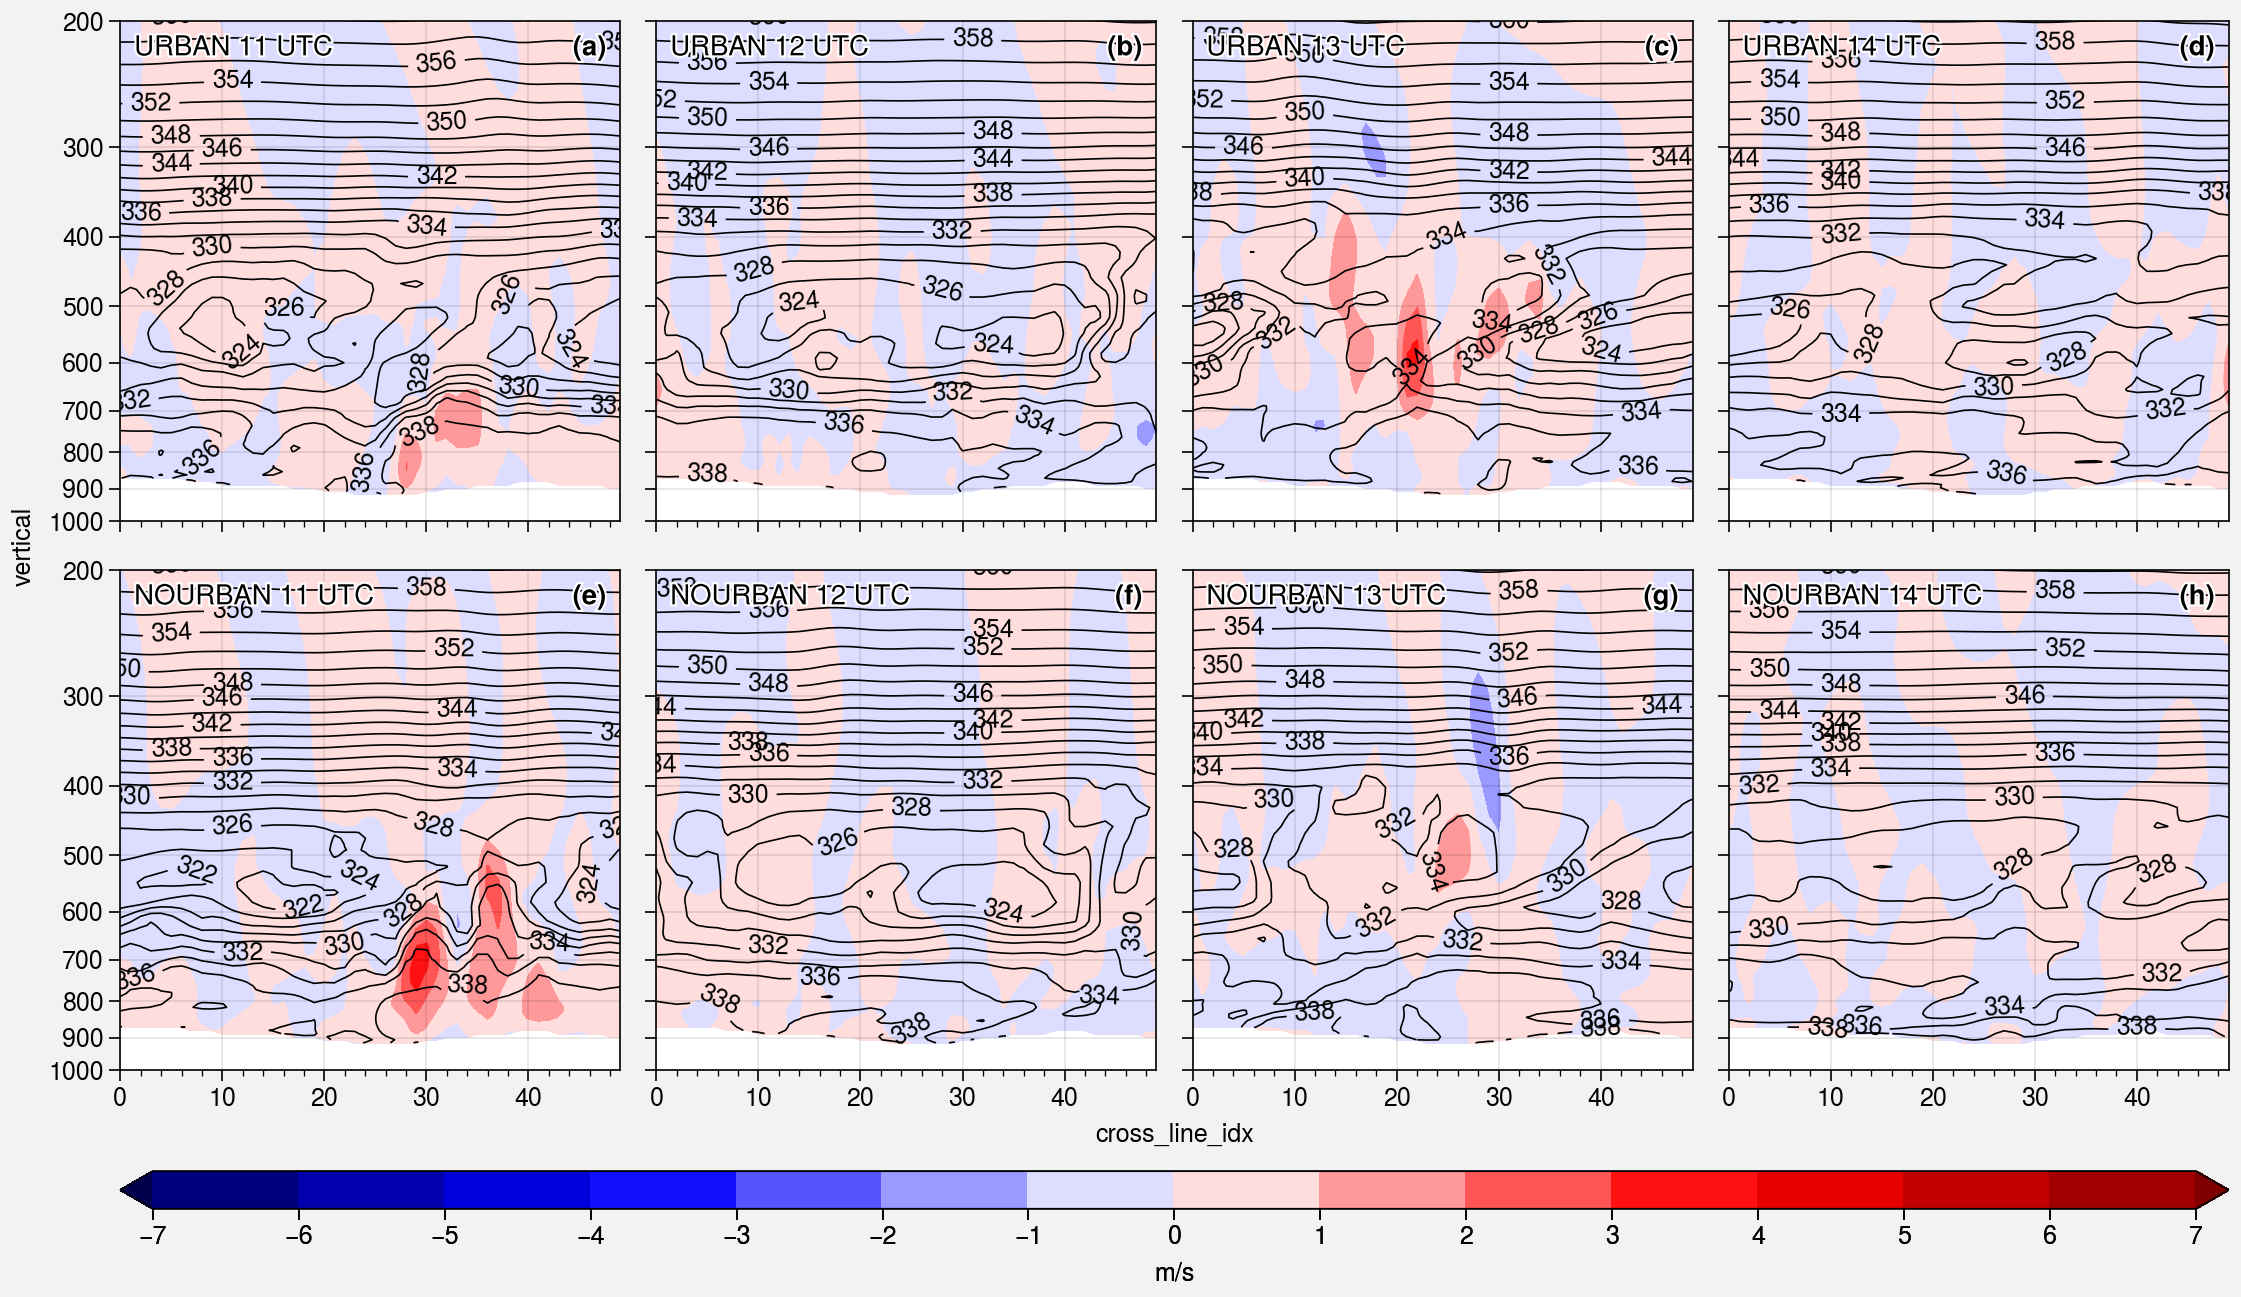

In [ ]:
run_save = 'URBANvsNOURBAN'
var_save = 'CrossSection_Theta_Buoyancy'
pre_pathing = r'C:\Users\User\New_PC\BitirmeTezi\Ensemble_Works\pictures'
pre_save = 'HOURLY'
pair_number = 'sw_ne'
season = 'Summer'
mphysics = 'Ens'
plot_facet_map(theta_e_data_urban = urban_ens_mean_daily_total,
               wa_data_urban = wa_urban_ens_mean_daily_total,
               theta_e_data_nourban = nourban_ens_mean_daily_total,
               wa_data_nourban = wa_nourban_ens_mean_daily_total,
               ncols = 4, nrows = 2,
               levels_theta_e = np.arange(310, 471, 2), 
               levels_wa = np.arange(-7, 8, 1),
               cmap = 'seismic',
               extend = 'both',
               ticks = np.arange(-7, 8, 1),
               cb_loc = 'b',
                run_save=run_save,
                var_save=var_save,
                pre_save = pre_save,
               pair_number = pair_number,
               season = season,
               mphysics = mphysics,
                draw_colorbar=True)